### Load libraries

In [715]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error

### Read in DF

In [747]:
all_df = pd.read_msgpack('feature_df.mp')

### Subset train df

Only between certain years, not rookie, change in BPM is not null (only if predicting delta)

In [748]:
train_df = all_df[
    (all_df['year'] > 1970) 
    & (all_df['year'] < 2015) 
    & (all_df['years_pro'] > 0) 
    &(all_df['diff'].notnull())
]

### Some LGB params

In [718]:

lgb_params = {
    'boosting_type': 'gbdt',
    'metric': ['rmse'],
    #'num_leaves': 20,
    'learning_rate': 0.05,
    #'feature_fraction': 0.6,
    #'bagging_fraction': 0.6,
    #'bagging_freq': 1,
    #'bagging_freq': 5,
    #'colsample_bytree': .4,
    #'min_data_in_leaf': 2,
    #'reg_alpha': 1,
    #'reg_lambda': 1,
    #'max_depth': 4,
    'verbose': 0
}

### Define X, y, drop any lookahead features

In [749]:
y_diff = train_df['diff']
y = train_df['bpm']
drop_cols =['id', 'ws', 'bpm', 'player_url', 'year', 'mp', 'diff']
X = train_df.drop(drop_cols, 1)
X_all = all_df.drop(drop_cols, 1)

### Define out-of-sample generator

In [720]:
from sklearn.model_selection import KFold
def get_out_of_sample(X, y, weights):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    all_preds = []
    all_models = []
    for train_index, test_index in kf.split(X):
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        weights_test = weights.iloc[test_index]
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        weights_train = weights.iloc[train_index]
        lgb_data = lgb.Dataset(X_train, y_train, weight=weights_train)
        out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
                     early_stopping_rounds=10,stratified=False)
        cv_loss = out['rmse-mean'][-1]
        cv_num_rounds = len(out['rmse-mean'])
        bst = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
        bst.fit(X_train, y_train, sample_weight=weights_train)
        preds = pd.Series(bst.predict(X_test), index=test_index)
        all_preds.append(preds)
        all_models.append(bst)
    return all_preds, all_models

### When training, care more about players with more minutes

Better actual estimate for their BPM

In [721]:
weights = np.log10(train_df['mp']+1) #* 0 + 1

In [722]:
diff_preds, diff_models = get_out_of_sample(X, y_diff, weights)

In [723]:
full_preds, full_models = get_out_of_sample(X, y, weights)

### Stacking

In [724]:
pred_df = train_df.copy()
diff_pred_series = pd.concat(diff_preds).sort_index()
full_pred_series = pd.concat(full_preds).sort_index()

In [725]:
pred_df['yhat_diff'] = diff_pred_series.values
pred_df['pred_full'] = full_pred_series.values
pred_df['pred_diff'] = pred_df['bpm___1'] + pred_df['yhat_diff']

In [726]:
mean_squared_error(pred_df['bpm'], pred_df['pred_diff'])

8.97233591651443

In [727]:
mean_squared_error(pred_df['bpm'], pred_df['pred_full'])

8.357813710038949

In [728]:
stacked_cols = ['mp___1', 'age', 'pred_full', 'pred_diff', 'mp___2', 'mp___3', 'years_pro', 'yhat_diff']

In [729]:
X_stacked = pred_df[stacked_cols]
X_stacked['arb_line'] = (X_stacked['mp___1'] > 200) & (X_stacked['age'] == 25) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [730]:
lgb_data = lgb.Dataset(X_stacked, y, weight=weights)
out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
             early_stopping_rounds=10,stratified=False)
cv_loss = out['rmse-mean'][-1]
cv_num_rounds = len(out['rmse-mean'])
cv_loss, cv_num_rounds

(2.318641210425634, 57)

In [731]:
bst_stacked = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
bst_stacked.fit(X_stacked, y, sample_weight=weights)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              metric=['rmse'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=57, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=0)

### Predict and transform back to BPM prediction

In [750]:
all_full_preds = []
for bst in full_models:
    all_full_preds.append(bst.predict(X_all))

In [751]:
all_diff_preds = []
for bst in diff_models:
    all_diff_preds.append(bst.predict(X_all))

In [752]:
all_full_pred_series = pd.DataFrame(all_full_preds).T.mean(axis=1)

In [753]:
all_diff_pred_series = pd.DataFrame(all_diff_preds).T.mean(axis=1)

In [754]:
all_pred_df = all_df.copy()
all_pred_df['pred_full'] = all_full_pred_series.values
all_pred_df['yhat_diff'] = all_diff_pred_series.values
all_pred_df['pred_diff'] = all_pred_df['yhat_diff'] + all_pred_df['bpm___1']

In [755]:
X_stacked_all = all_pred_df[stacked_cols]
X_stacked_all['arb_line'] = (X_stacked_all['mp___1'] > 200) & (X_stacked_all['age'] == 25) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [756]:
preds = bst_stacked.predict(X_stacked_all)

In [757]:
all_pred_df['pred'] = preds

### Look at predictions for recent year

In [758]:
recent = all_pred_df[(all_pred_df['year'] >= 2015) & (all_pred_df['year'] < 2020)].sort_values('pred')
recent = all_pred_df[(all_pred_df['year'] == 2020)].sort_values('pred')
recent = recent[(recent['years_pro'] > 0)]

In [759]:
recent.sort_values('pred', ascending=False)

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,bpm_diff,mp_diff,bpm_int,bpm_diff_2,bpm_age_int,diff,pred_full,yhat_diff,pred_diff,pred
21244,/players/h/hardeja01.html,2020,NaN,/players/h/hardeja01.html___2020,NaN,NaN,30,3.0,0,0,...,0.8,316.0,127.53,0.8,351.0,NaN,8.306861,-2.733253,8.966747,7.969218
21126,/players/a/antetgi01.html,2020,NaN,/players/a/antetgi01.html___2020,NaN,NaN,25,15.0,0,0,...,5.0,-398.0,62.64,-1.8,270.0,NaN,8.167716,-3.025269,7.774731,7.689030
21194,/players/d/davisan02.html,2020,NaN,/players/d/davisan02.html___2020,NaN,NaN,26,1.0,1,0,...,3.3,-877.0,44.20,1.5,221.0,NaN,6.909888,-1.362216,7.137784,6.795806
21285,/players/j/jokicni01.html,2020,NaN,/players/j/jokicni01.html___2020,NaN,NaN,24,41.0,1,0,...,2.4,61.0,67.45,-1.3,228.0,NaN,7.764652,-0.852852,8.647148,6.692190
21281,/players/j/jamesle01.html,2020,NaN,/players/j/jamesle01.html___2020,NaN,NaN,35,1.0,0,0,...,-1.5,-1089.0,77.76,1.2,283.5,NaN,7.071491,-1.154634,6.945366,6.275194
21232,/players/g/goberru01.html,2020,NaN,/players/g/goberru01.html___2020,NaN,NaN,27,27.0,1,0,...,2.7,761.0,30.10,-1.5,189.0,NaN,5.574425,-1.394905,5.605095,5.274666
21412,/players/t/townska01.html,2020,NaN,/players/t/townska01.html___2020,NaN,NaN,24,1.0,1,0,...,1.3,-373.0,37.40,0.6,163.2,NaN,5.849422,-0.510296,6.289704,5.205835
21192,/players/c/curryst01.html,2020,NaN,/players/c/curryst01.html___2020,NaN,NaN,31,7.0,0,0,...,-2.3,700.0,54.18,1.3,195.3,NaN,5.496562,-0.925528,5.374472,5.054685
21433,/players/w/westbru01.html,2020,NaN,/players/w/westbru01.html___2020,NaN,NaN,31,4.0,0,0,...,-1.7,-284.0,53.30,-7.4,201.5,NaN,5.331632,-0.528381,5.971619,5.007920
21308,/players/l/lillada01.html,2020,NaN,/players/l/lillada01.html___2020,NaN,NaN,29,6.0,0,0,...,-1.2,168.0,36.85,2.4,159.5,NaN,4.928577,-0.550443,4.949557,4.368161


In [709]:
missing = recent[recent['bpm___1'].isnull()]
regular = recent[recent['bpm___1'].notnull()]

In [710]:
mean_squared_error(missing['bpm'], missing['pred_full'])

69.76207356830554

In [711]:
mean_squared_error(missing['bpm'], missing['pred'])

65.86656558475445

In [712]:
mean_squared_error(regular['bpm'], regular['pred_full'])

8.232545589862715

In [713]:
mean_squared_error(regular['bpm'], regular['pred_diff'])

10.283220654129776

In [714]:
mean_squared_error(regular['bpm'], regular['pred'])

8.091074807866644

### Look into data!!

In [64]:
recent1 = recent.copy()

In [86]:
from sklearn.metrics import mean_squared_error

In [89]:
merged = recent1[['id', 'bpm___1', 'mp___1', 'age', 'pred', 'bpm']].merge(recent[['id', 'pred']], how='left', on='id')

In [90]:
merged_non_null = merged.dropna(subset=['pred_x', 'pred_y'])

In [209]:
mask = (merged_non_null['mp___1'] > 200) & (merged_non_null['age'] == 25) #& ((merged_non_null['age'] > 20))

In [210]:
x = merged_non_null[mask]
y = merged_non_null[~mask]

In [211]:
mean_squared_error(x['bpm'], x['pred_x'])

8.780145287223327

In [212]:
mean_squared_error(x['bpm'], x['pred_y'])

8.653732395852703

In [140]:
mean_squared_error(y['bpm'], y['pred_x'])

10.699878754390257

In [141]:
mean_squared_error(y['bpm'], y['pred_y'])

14.413941458386493

In [233]:
zs = []
for age in range(20, 38):
    mask = (merged_non_null['mp___1'] > 300) & (merged_non_null['age'] == age) #& ((merged_non_null['age'] > 20))
    x = merged_non_null[mask]
    y = merged_non_null[~mask]
    z = mean_squared_error(x['bpm'], x['pred_x']) - mean_squared_error(x['bpm'], x['pred_y'])
    zs.append(z)

In [234]:
%matplotlib inline

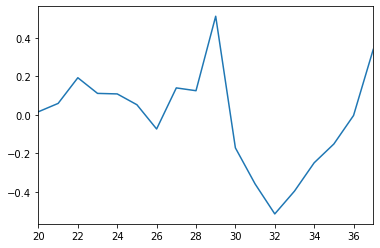

In [235]:
pd.Series(zs, index=range(20,38)).plot()

In [704]:
def max_bpm(row):
    return row[['bpm___1', 'bpm___2', 'bpm___3']].max()

In [705]:
recent['delta'] = recent['pred'] - recent.apply(max_bpm, axis=1)* 1

In [706]:
recent.sort_values('delta', ascending=False)[lambda x: x['pred'] > .5]

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,mp_diff,bpm_int,bpm_diff_2,bpm_age_int,diff,pred_full,yhat_diff,pred_diff,pred,delta
21274,/players/g/gilgesh01.html,2020,3.3,/players/g/gilgesh01.html___2020,-0.3,2174,21,11.0,0,0,...,NaN,NaN,NaN,-6.3,0.0,0.423441,0.764131,0.464131,0.505173,0.805173
21139,/players/a/aytonde01.html,2020,5.8,/players/a/aytonde01.html___2020,0.2,2183,21,1.0,1,0,...,NaN,NaN,NaN,4.2,0.0,0.901359,0.785242,0.985242,0.954825,0.754825
21335,/players/j/jacksja02.html,2020,3.3,/players/j/jacksja02.html___2020,0.1,1515,20,4.0,0,0,...,NaN,NaN,NaN,2.0,0.0,0.485060,0.628590,0.728590,0.765176,0.665176
21127,/players/a/allenja01.html,2020,7.6,/players/a/allenja01.html___2020,2.5,2096,21,22.0,1,0,...,655.0,0.50,NaN,52.5,0.0,2.511035,-0.110771,2.389229,2.939637,0.439637
21262,/players/f/foxde01.html,2020,5.6,/players/f/foxde01.html___2020,1.1,2546,22,5.0,0,0,...,520.0,-4.84,NaN,24.2,0.0,1.471061,0.303991,1.403991,1.403244,0.303244
21239,/players/d/doncilu01.html,2020,4.9,/players/d/doncilu01.html___2020,4.1,2318,20,3.0,0,0,...,NaN,NaN,NaN,82.0,0.0,3.634287,0.638219,4.738219,4.336556,0.236556
21173,/players/b/bookede01.html,2020,3.5,/players/b/bookede01.html___2020,0.8,2242,23,13.0,0,0,...,377.0,0.32,2.7,18.4,0.0,0.727663,-0.018841,0.781159,0.985310,0.185310
21541,/players/w/whitede01.html,2020,3.6,/players/w/whitede01.html___2020,0.9,1728,25,29.0,0,0,...,1589.0,0.45,NaN,22.5,0.0,0.559020,-0.160955,0.739045,0.905460,0.005460
21277,/players/g/gordoaa01.html,2020,5.1,/players/g/gordoaa01.html___2020,1.0,2633,24,4.0,0,0,...,724.0,0.00,0.7,24.0,0.0,0.728823,-0.134171,0.865829,0.967520,-0.032480
21209,/players/c/collijo01.html,2020,6.0,/players/c/collijo01.html___2020,1.4,1829,22,19.0,0,0,...,44.0,2.38,NaN,30.8,0.0,1.646011,0.428990,1.828990,1.639656,-0.060344
